# ECG signal processing and feature extraction

In this notebook, we embark on a comprehensive journey of ECG signal processing and analysis. Our primary objectives include the preprocessing of ECG signals through filtering, noise reduction, and resampling techniques. We ensure the quality of our data by visualizing these processed signals. Moving forward, we delve into feature extraction, encompassing fundamental aspects such as amplitude, duration, and intervals. Additionally, we explore advanced techniques like wavelet transform for more in-depth feature extraction. To facilitate the analysis and classification of ECG segments, we generate labels based on annotated arrhythmia types, making this project a vital endeavor in the realm of cardiac health monitoring and diagnosis.

In [58]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import pywt
from biosppy.signals import ecg
import wfdb
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [29]:
# Load the ECG signal (you'll need to adapt this to your dataset)
record_name = 'mit-bih-supraventricular-arrhythmia-database-1.0.0/801'  # Replace with your ECG record name
record = wfdb.rdrecord(record_name, sampfrom=100, sampto=2100)
ecg_signal = record.p_signal[:, 0]  # Assuming a single-channel ECG

In [54]:
# Define a function for ECG preprocessing
def preprocess_ecg(ecg_signal):
    # Median filtering
    filtered_signal = signal.medfilt(ecg_signal, kernel_size=3)
    
    # Resample to a new length (adjust 'new_length' as needed)
    new_length = 1000
    resampled_signal = signal.resample(filtered_signal, new_length)
    
    return resampled_signal

In [46]:
# Apply ECG preprocessing
preprocessed_ecg = preprocess_ecg(ecg_signal)

In [48]:
preprocessed_ecg

array([-0.02711589,  0.19846977,  0.37906896,  0.67596155,  0.82314483,
        0.67874385, -0.46517091, -1.79396634, -2.86272447, -2.54721851,
       -1.17810392, -0.455379  , -0.30309973, -0.24019072, -0.23706816,
       -0.12450457,  0.08369991,  0.36392686,  0.62200617,  0.86210563,
        1.01560964,  1.14125823,  1.00519721,  0.93886895,  0.75775662,
        0.54534802,  0.45401738,  0.37531435,  0.31574601,  0.30624406,
        0.34438588,  0.3539628 ,  0.33252186,  0.29336165,  0.22221321,
        0.12284979,  0.08134762,  0.15286984,  0.1911221 ,  0.22252072,
        0.43582128,  0.47445832,  0.1419441 , -0.08855041, -0.08748038,
       -0.09531192, -0.07537329, -0.15804137, -0.06449671,  0.20629422,
        0.88777232,  0.62193806, -0.29997424, -0.49418932, -0.48844498,
       -0.58121862, -0.74946531, -0.81498162, -0.90687997, -1.07921284,
       -1.09308906, -1.36052666, -1.4391044 , -1.32490812, -1.28426022,
       -0.97763155, -0.65752772, -0.18771146,  0.06605665,  0.25

## Visualize Preprocessed ECG Signal vs the raw ECG signal

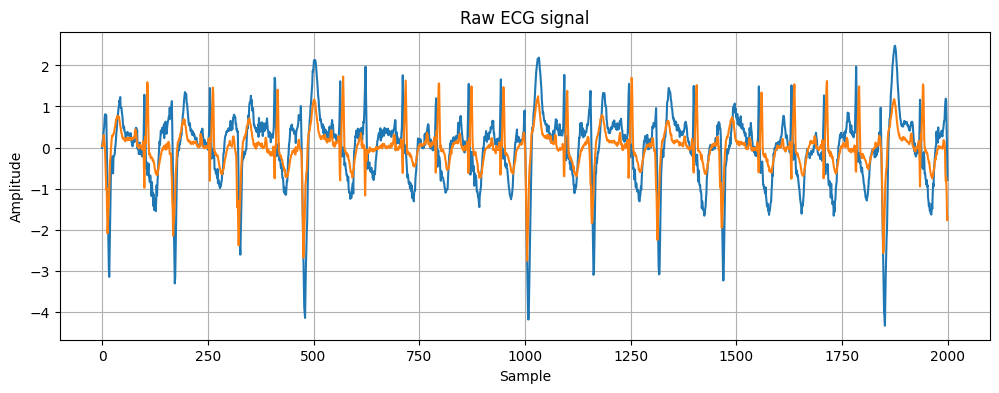

Signal length: 2000


In [50]:
# Plot the ECG signal
plt.figure(figsize=(12, 4))
plt.plot(record.p_signal)
plt.title('Raw ECG signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
print("Signal length: " + str(len(record.p_signal)))

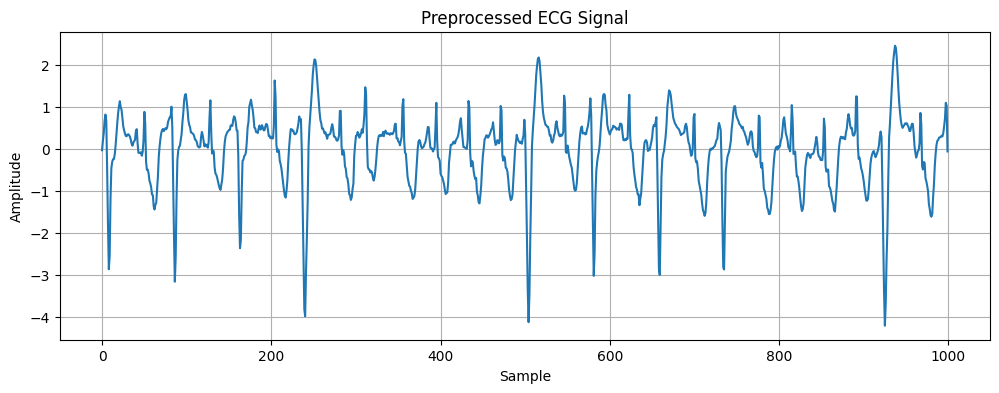

In [49]:
plt.figure(figsize=(12, 4))
plt.plot(resampled_signal)
plt.title('Preprocessed ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## Feature extraction

In [33]:
mean_amplitude = np.mean(resampled_signal)
max_amplitude = np.max(resampled_signal)
min_amplitude = np.min(resampled_signal)
print(mean_amplitude)
print(max_amplitude)
print(min_amplitude)

0.004002499999999996
2.4635067083496205
-4.208073647570785


### Wavelet transform

In [34]:
coeffs = pywt.wavedec(resampled_signal, 'db4', level=5)  # 5-level decomposition
wavelet_features = np.hstack(coeffs)  # Concatenate coefficients as features

## Label Generation

In [35]:
# Load the associated annotation
annotation = wfdb.rdann(record_name, 'atr',shift_samps=True, sampfrom=100, sampto=2100)
annotation

In [36]:
# Extract beat locations and types
beat_samples = annotation.sample
beat_types = annotation.symbol

In [38]:
beat_types

['V',
 'N',
 'V',
 'N',
 'V',
 'N',
 'V',
 'N',
 'V',
 'N',
 'N',
 'N',
 'N',
 'V',
 'N',
 'V',
 'N',
 'V',
 'N',
 'V',
 'N',
 'N',
 'N',
 'N',
 'V',
 'N',
 'V']

In [39]:
# Define a mapping of beat type codes to labels (customize as needed)
beat_type_mapping = {
    'N': 'Normal',
    'L': 'Left bundle branch block',
    'R': 'Right bundle branch block',
    'A': 'Atrial premature beat',
    'V': 'Premature ventricular contraction',
    'F': 'Fusion of ventricular and normal beat',
    'J': 'Nodal (junctional) premature beat',
    'E': 'Atrial escape beat',
    'a': 'Aberrated atrial premature beat',
    'S': 'Supraventricular premature or ectopic beat',
    'J': 'Nodal (junctional) escape beat',
    'e': 'Ventricular escape beat',
    'Q': 'Unclassifiable beat',
    
}

In [61]:
# Initialize an empty list to store labels
labels = []

# Initialize prev_beat_sample
prev_beat_sample = 0

# Iterate through beat annotations
for i in range(len(annotation.symbol)):
    beat_type = annotation.symbol[i]  # Get the beat type (e.g., 'N', 'L', 'R', 'A', etc.)
    beat_sample = annotation.sample[i]  # Get the sample index of the beat

    # Determine the label based on beat type (using the beat_type_mapping dictionary)
    if beat_type in beat_type_mapping:
        label = beat_type_mapping[beat_type]
    else:
        label = 'Other'  # Handle unknown beat types as 'Other' or any appropriate label
    
    # Append the label to the 'labels' list at the corresponding sample index
    labels.extend([label] * (beat_sample - prev_beat_sample))  # Extend with repeated labels
    prev_beat_sample = beat_sample



In [62]:
labels

['Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Premature ventricular contraction',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Nor